In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`head_direction-users.ipynb`**. See the button at the top right to download as markdown or pdf.

:::
# Fit head-direction population
This notebook has had all its explanatory text removed and has not been run.
 It is intended to be downloaded and run locally (or on the provided binder)
 while listening to the presenter's explanation. In order to see the fully
 rendered of this notebook, go [here](../../full/day2/head_direction.md)
## Learning objectives

- Include history-related predictors to NeMoS GLM.
- Reduce over-fitting with `Basis`.
- Learn functional connectivity.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots
import workshop_utils

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

# configure plots some
plt.style.use(nmo.styles.plot_style)

## Data Streaming

- Fetch the data.

In [3]:
path = workshop_utils.fetch.fetch_data("Mouse32-140822.nwb")

## Pynapple

- `load_file` : open the NWB file and give a preview.

In [4]:
data = nap.load_file(path)

data

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Mouse32-140822
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                 │ TsGroup     │
│ sws                   │ IntervalSet │
│ rem                   │ IntervalSet │
│ position_time_support │ IntervalSet │
│ epochs                │ IntervalSet │
│ ry                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙

- Load the units

In [5]:
spikes = data["units"]

spikes

Index    rate     location    group
-------  -------  ----------  -------
0        2.96981  thalamus    1
1        2.42638  thalamus    1
2        5.93417  thalamus    1
3        5.04432  thalamus    1
4        0.30207  adn         2
5        0.87042  adn         2
6        0.36154  adn         2
...      ...      ...         ...
42       1.02061  thalamus    5
43       6.84913  thalamus    6
44       0.94002  thalamus    6
45       0.55768  thalamus    6
46       1.15056  thalamus    6
47       0.46084  thalamus    6
48       0.19287  thalamus    7

- Load the epochs and take only wakefulness

In [6]:
epochs = data["epochs"]
wake_epochs = epochs[epochs.tags == "wake"]

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/io/interface_nwb.py:90: UserWarning: DataFrame is not sorted by start times. Sorting it.
  data = nap.IntervalSet(df)


- Load the angular head-direction of the animal (in radians)

In [7]:
angle = data["ry"]

- Select only those units that are in ADn
- Restrict the activity to wakefulness (both the spiking activity and the angle)

In [8]:
spikes = spikes[spikes.location == "adn"]

spikes = spikes.restrict(wake_epochs).getby_threshold("rate", 1.0)
angle = angle.restrict(wake_epochs)

- Compute tuning curves as a function of head-direction

In [9]:
tuning_curves = nap.compute_1d_tuning_curves(
    group=spikes, feature=angle, nb_bins=61, minmax=(0, 2 * np.pi)
)

- Plot the tuning curves.

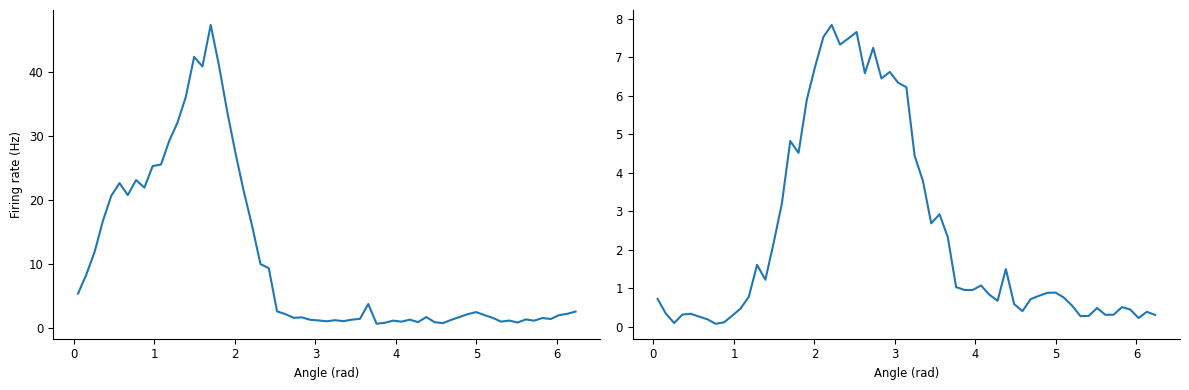

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(tuning_curves.iloc[:, 0])
ax[0].set_xlabel("Angle (rad)")
ax[0].set_ylabel("Firing rate (Hz)")
ax[1].plot(tuning_curves.iloc[:, 1])
ax[1].set_xlabel("Angle (rad)")
plt.tight_layout()

- Let's visualize the data at the population level.

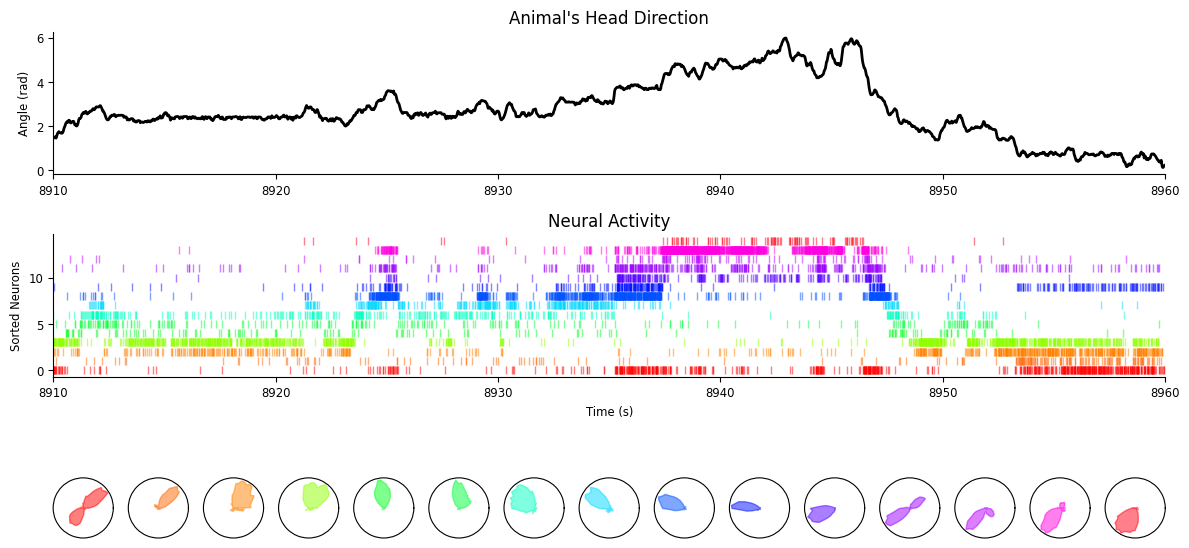

In [11]:
fig = workshop_utils.plot_head_direction_tuning_model(
    tuning_curves, spikes, angle, threshold_hz=1, start=8910, end=8960
)

- Define a `wake_ep` IntervalSet with the first 3 minutes of wakefulness (to speed up model fitting).

In [12]:
wake_ep = nap.IntervalSet(wake_epochs[0].start, wake_epochs[0].start + (60 * 3))

In [13]:
wake_epochs

  index    start      end  tags
      0   8812.3  10771.3  ['wake']
shape: (1, 2), time unit: sec.

In [14]:
wake_ep

  index    start     end
      0   8812.3  8992.3
shape: (1, 2), time unit: sec.

- bin the spike trains in 10 ms bin (`count = ...`).

In [15]:
bin_size = 10 #ms
count = spikes.count(bin_size=bin_size, time_units='ms')

- sort the neurons by their preferred direction using pandas:
    - Preferred angle:  `pref_ang = tuning_curves.idxmax()`.
    - Define a new `count` TsdFrame, sorting the columns according to `pref_ang`.

In [16]:
count

Time (s)    7    9    10    12    13    ...
----------  ---  ---  ----  ----  ----  -----
8812.305    0.0  0.0  0.0   0.0   0.0   ...
8812.315    1.0  0.0  0.0   0.0   0.0   ...
8812.325    0.0  0.0  0.0   0.0   0.0   ...
8812.335    0.0  0.0  0.0   0.0   0.0   ...
8812.345    1.0  0.0  0.0   0.0   0.0   ...
8812.355    0.0  0.0  0.0   0.0   0.0   ...
8812.365    1.0  0.0  0.0   0.0   0.0   ...
...         ...  ...  ...   ...   ...   ...
10771.235   0.0  0.0  0.0   0.0   0.0   ...
10771.245   0.0  0.0  0.0   0.0   0.0   ...
10771.255   1.0  0.0  0.0   0.0   0.0   ...
10771.265   0.0  0.0  0.0   0.0   0.0   ...
10771.275   0.0  0.0  0.0   0.0   0.0   ...
10771.285   0.0  0.0  0.0   0.0   0.0   ...
10771.295   0.0  0.0  0.0   0.0   0.0   ...
dtype: float64, shape: (195900, 19)

In [17]:
pref_ang = tuning_curves.idxmax()
pref_ang

7     1.699550
9     2.214565
10    4.171623
12    2.317568
13    0.978529
14    0.566517
17    4.171623
18    3.450602
20    0.978529
21    1.699550
22    3.965617
23    5.407659
24    4.583635
25    2.729581
26    5.201653
29    3.038590
30    4.274626
33    3.656608
34    0.875526
dtype: float64

In [18]:
np.argsort(pref_ang)

7      5
9     18
10     8
12     4
13     0
14     9
17     1
18     3
20    13
21    15
22     7
23    17
24    10
25     2
26     6
29    16
30    12
33    14
34    11
dtype: int64

In [19]:
pref_ang.iloc[np.argsort(pref_ang)]

14    0.566517
34    0.875526
20    0.978529
13    0.978529
7     1.699550
21    1.699550
9     2.214565
12    2.317568
25    2.729581
29    3.038590
18    3.450602
33    3.656608
22    3.965617
10    4.171623
17    4.171623
30    4.274626
24    4.583635
26    5.201653
23    5.407659
dtype: float64

In [20]:
count = spikes.count(bin_size=bin_size, time_units='ms')
pref_ang = tuning_curves.idxmax()
idx = np.argsort(pref_ang)
# sort the columns by angle
count = nap.TsdFrame(
    t=count.t,
    d=count.d[:,idx],
    columns=count.columns[idx],
    time_support=count.time_support,
)

In [21]:
count

Time (s)    14    34    20    13    7    ...
----------  ----  ----  ----  ----  ---  -----
8812.305    1.0   0.0   0.0   0.0   0.0  ...
8812.315    1.0   0.0   0.0   0.0   1.0  ...
8812.325    1.0   0.0   0.0   0.0   0.0  ...
8812.335    3.0   0.0   0.0   0.0   0.0  ...
8812.345    0.0   0.0   0.0   0.0   1.0  ...
8812.355    0.0   0.0   0.0   0.0   0.0  ...
8812.365    0.0   0.0   0.0   0.0   1.0  ...
...         ...   ...   ...   ...   ...  ...
10771.235   0.0   0.0   0.0   0.0   0.0  ...
10771.245   0.0   0.0   0.0   0.0   0.0  ...
10771.255   0.0   0.0   0.0   0.0   1.0  ...
10771.265   0.0   0.0   0.0   0.0   0.0  ...
10771.275   0.0   0.0   0.0   0.0   0.0  ...
10771.285   0.0   0.0   0.0   0.0   0.0  ...
10771.295   0.0   0.0   0.0   0.0   0.0  ...
dtype: float64, shape: (195900, 19)

## NeMoS 
### Self-Connected Single Neuron

- Start with modeling a self-connected single neuron.
- Select a neuron (call the variable `neuron_count`).
- Select the first 1.2 seconds for visualization. (call the epoch `epoch_one_spk`).

In [22]:
# select neuron 0 spike count time series
neuron_count = count[:,0]
# restrict to a smaller time interval (1.2 sec)
epoch_one_spk = nap.IntervalSet(neuron_count.time_support.start[0], neuron_count.time_support.start[0] + 1.2)

In [23]:
epoch_one_spk

  index    start     end
      0   8812.3  8813.5
shape: (1, 2), time unit: sec.

In [24]:
np.sum(neuron_count.restrict(epoch_one_spk))

np.float64(65.0)

In [25]:
window_size_sec

NameError: name 'window_size_sec' is not defined

#### Features Construction

- Fix a history window of 800ms (0.8 seconds).
- Plot the result using `doc_plots.plot_history_window`

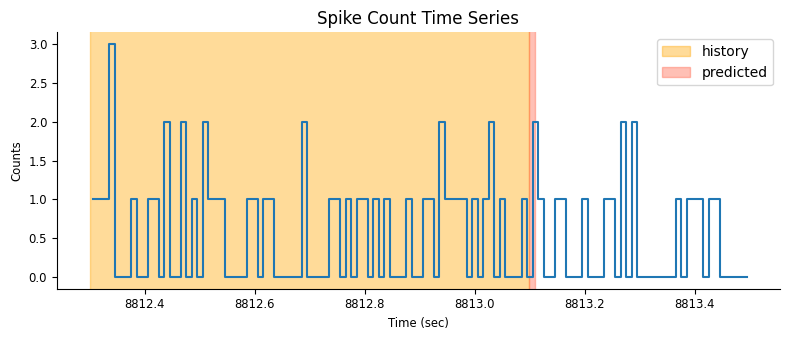

In [26]:
# set the size of the spike history window in seconds
window_size_sec = 0.8

doc_plots.plot_history_window(neuron_count, epoch_one_spk, window_size_sec);

- By shifting the time window we can predict new count bins.
- Concatenating all the shifts, we form our feature matrix.

In [27]:
doc_plots.run_animation(neuron_count, epoch_one_spk.start[0])

- This is equivalent to convolving `count` with an identity matrix.
- That's what NeMoS `HistoryConv` basis is for: 
    - Convert the window size in number of bins (call it `window_size`)
    - Define an `HistoryConv` basis covering this window size (call it `history_basis`).
    - Create the feature matrix with `history_basis.compute_features` (call it `input_feature`).

In [28]:
# convert the prediction window to bins (by multiplying with the sampling rate)
window_size = int(window_size_sec * neuron_count.rate)
# define the history bases
history_basis = nmo.basis.HistoryConv(window_size)
# create the feature matrix
input_feature = history_basis.compute_features(neuron_count)

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/core/time_series.py:300: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  out = func._implementation(*new_args, **kwargs)


- NeMoS NaN pads if there aren't enough samples to predict the counts.

NaN indices:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


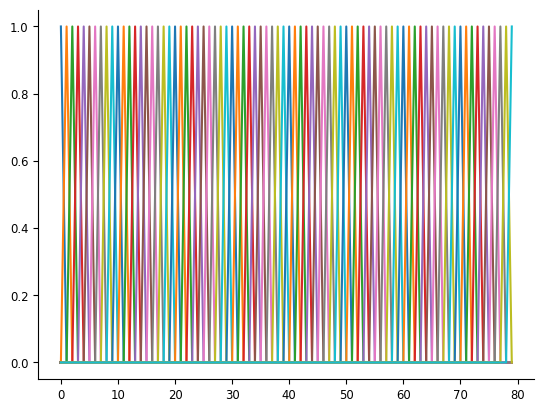

In [29]:
# print the NaN indices along the time axis
print("NaN indices:\n", np.where(np.isnan(input_feature[:, 0]))[0]) 
_, kernel = history_basis.evaluate_on_grid(window_size)
plt.plot(kernel);

- Check the shape of the counts and features.

- Plot the convolution output with `workshop_utils.plot_features`.

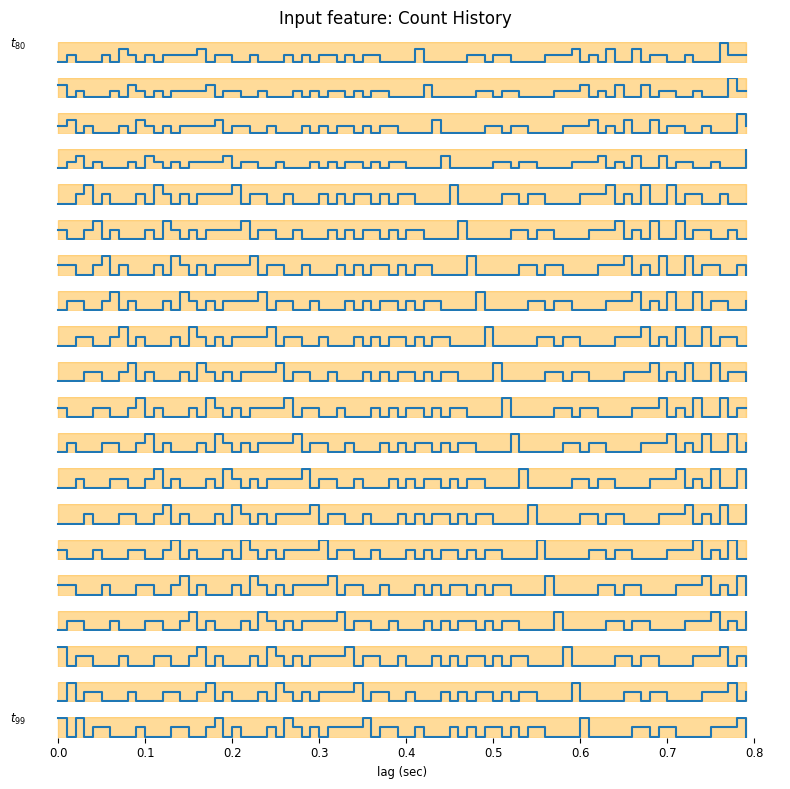

In [30]:
suptitle = "Input feature: Count History"
neuron_id = 0
workshop_utils.plot_features(input_feature, count.rate, suptitle);

#### Fitting the Model

- Split your epochs in two for validation purposes:
    - Define two `IntervalSet`s, each with half of the `input_feature.time_support` duration

In [31]:
# construct the train and test epochs
duration = input_feature.time_support.tot_length("s")
start = input_feature.time_support["start"]
end = input_feature.time_support["end"]

# define the interval sets
first_half = nap.IntervalSet(start, start + duration / 2)
second_half = nap.IntervalSet(start + duration / 2, end)

- Fit a GLM to the first half.

In [32]:
# define the GLM object
model = nmo.glm.GLM(solver_name='LBFGS')
# Fit over the training epochs
model.fit(input_feature.restrict(first_half), neuron_count.restrict(first_half))

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

In [33]:
model

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

- Plot the weights (`model.coef_`).

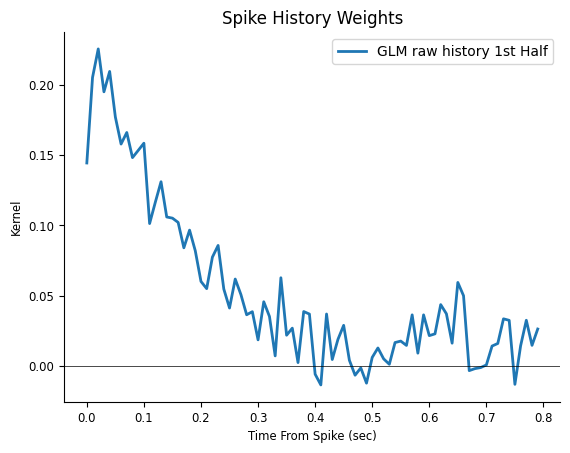

In [34]:
plt.figure()
plt.title("Spike History Weights")
plt.plot(np.arange(window_size) / count.rate, np.squeeze(model.coef_), lw=2, label="GLM raw history 1st Half")
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time From Spike (sec)")
plt.ylabel("Kernel")
plt.legend()

#### Inspecting the results

- Fit on the other half.

In [35]:
# fit on the test set
model_second_half = nmo.glm.GLM(solver_name='LBFGS')
model_second_half.fit(input_feature.restrict(second_half), neuron_count.restrict(second_half))

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

- Compare results.

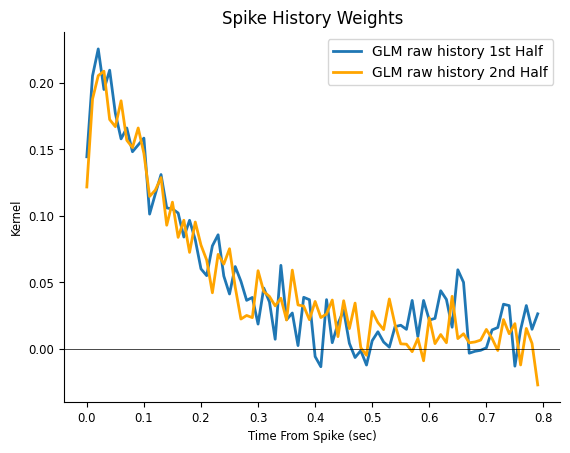

In [36]:
plt.figure()
plt.title("Spike History Weights")
plt.plot(np.arange(window_size) / count.rate, np.squeeze(model.coef_),
         label="GLM raw history 1st Half", lw=2)
plt.plot(np.arange(window_size) / count.rate,  np.squeeze(model_second_half.coef_),
         color="orange", label="GLM raw history 2nd Half", lw=2)
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time From Spike (sec)")
plt.ylabel("Kernel")
plt.legend()

#### Reducing feature dimensionality

- Visualize the raised cosine basis.

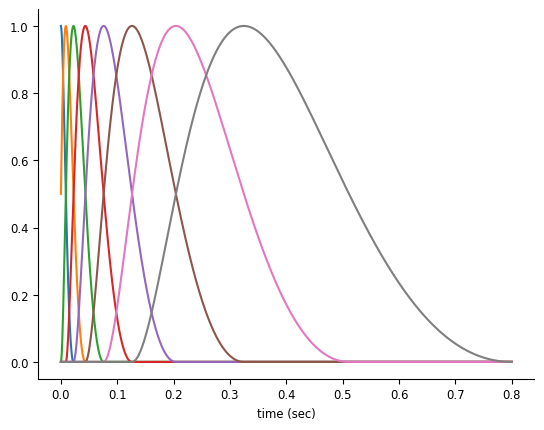

In [37]:
doc_plots.plot_basis();

- Define the basis `RaisedCosineLogConv`and name it `basis`. 
- Basis parameters:
    - 8 basis functions.
    - Window size of 0.8sec.

In [38]:
window_size

80

In [39]:
# a basis object can be instantiated in "conv" mode for convolving  the input.
basis = nmo.basis.RaisedCosineLogConv(8, window_size) # 10ms bins, so 80 * 10 = 0.8 sec

- Convolve the counts with the basis functions. (Call the output `conv_spk`)
- Print the shape of `conv_spk` and compare it to `input_feature`.

In [40]:
# convolve the basis
conv_spk = basis.compute_features(neuron_count)
# print the shape
print(f"Raw count history as feature: {input_feature.shape}")
print(f"Compressed count history as feature: {conv_spk.shape}")

Raw count history as feature: (195900, 80)
Compressed count history as feature: (195900, 8)


/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/core/time_series.py:300: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  out = func._implementation(*new_args, **kwargs)


- Visualize the output.

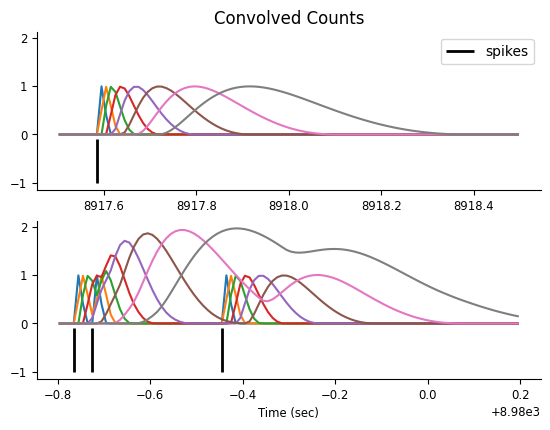

In [41]:
# Visualize the convolution results
epoch_one_spk = nap.IntervalSet(8917.5, 8918.5)
epoch_multi_spk = nap.IntervalSet(8979.2, 8980.2)

doc_plots.plot_convolved_counts(neuron_count, conv_spk, epoch_one_spk, epoch_multi_spk);

#### Fit and compare the models

- Fit the model using the compressed features. Call it `model_basis`.

In [43]:
# use restrict on interval set training and fit a GLM
model_basis = nmo.glm.GLM().fit(conv_spk, neuron_count)

- Reconstruct the history filter:
    - Extract the basis kernels with `_, basis_kernels = basis.evaluate_on_grid(window_size)`.
    - Multiply the `basis_kernel` with the coefficient using `np.matmul`.
- Check the shape of `self_connection`.

In [46]:
# get the basis function kernels
_, basis_kernels = basis.evaluate_on_grid(window_size)
# multiply with the weights
self_connection = np.matmul(basis_kernels, model_basis.coef_)
# print the shape of self_connection
self_connection.shape

(80,)

- Check if with less parameter we are not over-fitting.
- Fit the other half of the data. Name it `model_basis_second_half`.

In [47]:
model_basis_second_half = nmo.glm.GLM(solver_name='LBFGS').fit(conv_spk.restrict(second_half), neuron_count.restrict(second_half))

- Get the response filters: multiply the `basis_kernels` with the weights from `model_basis_second_half`.
- Call the output `self_connection_second_half`.

In [48]:
self_connection_second_half = np.matmul(basis_kernels, model_basis_second_half.coef_)

- Plot and compare the results.

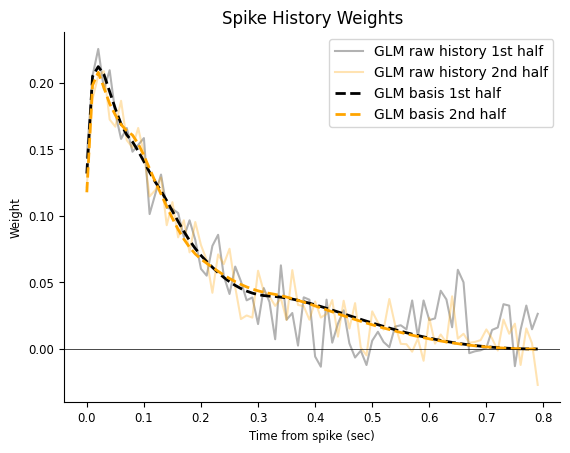

In [49]:
time = np.arange(window_size) / count.rate
plt.figure()
plt.title("Spike History Weights")
plt.plot(time, np.squeeze(model.coef_), "k", alpha=0.3, label="GLM raw history 1st half")
plt.plot(time, np.squeeze(model_second_half.coef_), alpha=0.3, color="orange", label="GLM raw history 2nd half")
plt.plot(time, self_connection, "--k", lw=2, label="GLM basis 1st half")
plt.plot(time, self_connection_second_half, color="orange", lw=2, ls="--", label="GLM basis 2nd half")
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time from spike (sec)")
plt.ylabel("Weight")
plt.legend()

- Predict the rates from `model` and `model_basis`. Call it `rate_history` and `rate_basis`.
- Convert the rate from spike/bin to spike/sec by multiplying with `conv_spk.rate`.

In [50]:
rate_basis = model_basis.predict(conv_spk) * count.rate
rate_history = model.predict(input_feature) * count.rate

- Plot the results.

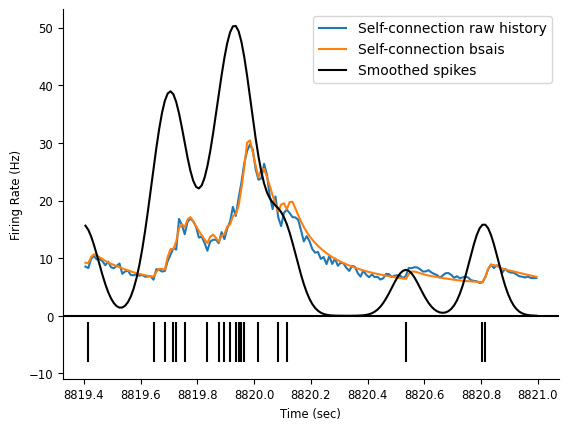

In [51]:
ep = nap.IntervalSet(start=8819.4, end=8821)
# plot the rates
doc_plots.plot_rates_and_smoothed_counts(
    neuron_count,
    {"Self-connection raw history":rate_history, "Self-connection bsais": rate_basis}
);

### All-to-all Connectivity
#### Preparing the features

- Re-define the basis.
- Convolve all counts. Call the output in `convolved_count`.
- Print the output shape

In [53]:
# reset the input shape by passing the pop. count
basis = nmo.basis.RaisedCosineLogConv(8, window_size)
# convolve all the neurons
convolved_count = basis.compute_features(count)
print(count.shape, convolved_count.shape)

(195900, 19) (195900, 152)


/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/core/time_series.py:300: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  out = func._implementation(*new_args, **kwargs)


#### Fitting the Model

- Fit a `PopulationGLM`, call the object `model`
- Use Ridge regularization with a `regularizer_strength=0.1`
- Print the shape of the estimated coefficients.

In [54]:
model = nmo.glm.PopulationGLM(
    regularizer='Ridge',
    regularizer_strength=0.1,
    solver_name='LBFGS',
).fit(convolved_count.restrict(first_half), count.restrict(first_half))
print(f"Model coefficients shape: {model.coef_.shape}")

Model coefficients shape: (152, 19)


#### Comparing model predictions.

- Predict the firing rate of each neuron. Call it `predicted_firing_rate`.
- Convert the rate from spike/bin to spike/sec.

In [56]:
predicted_firing_rate = model.predict(convolved_count) * count.rate
predicted_firing_rate.shape

(195900, 19)

- Visualize the predicted rate and tuning function.

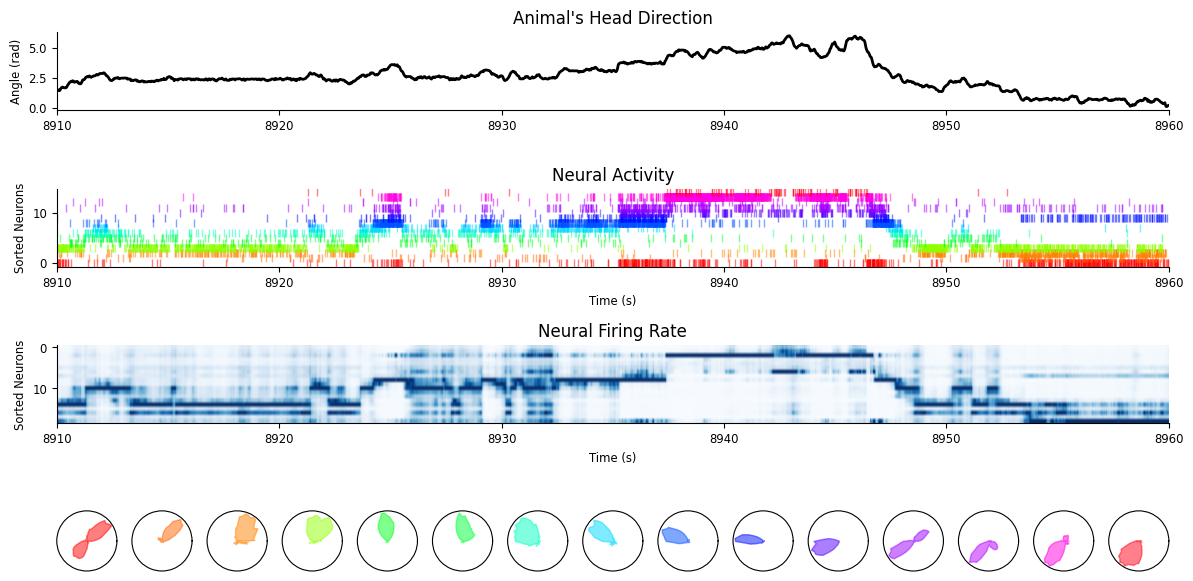

In [58]:
# use pynapple for time axis for all variables plotted for tick labels in imshow
workshop_utils.plot_head_direction_tuning_model(tuning_curves, spikes, angle, 
                                                predicted_firing_rate, threshold_hz=1,
                                                start=8910, end=8960, cmap_label="hsv");

- Visually compare all the models.

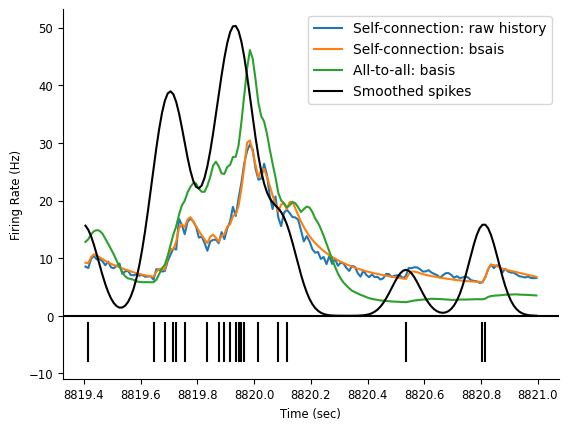

In [57]:
fig = doc_plots.plot_rates_and_smoothed_counts(
    neuron_count,
    {"Self-connection: raw history": rate_history,
     "Self-connection: bsais": rate_basis,
     "All-to-all: basis": predicted_firing_rate[:, 0]}
)

#### Visualizing the connectivity

- Check the shape of the weights.

In [ ]:
# enter code here

- Reshape the weights with `basis.split_by_feature` (returns a dictionary).


![Reshape coefficients](../../docs/source/_static/coeff_reshape.png)

In [65]:
# split the coefficient vector along the feature axis (axis=0)
weights_dict = basis.split_by_feature(model.coef_, axis=0)
# visualize the content
print(weights_dict['RaisedCosineLogConv'].shape) ; print(model.coef_.shape)

(19, 8, 19)
(152, 19)


- Get the weight array from the dictionary (and call the output `weights`). 
- Print the new shape of the weights.

In [66]:
# get the coefficients
weights = weights_dict['RaisedCosineLogConv']
# print the shape
print(weights.shape)

(19, 8, 19)


- The shape is `(sender_neuron, num_basis, receiver_neuron)`.
- Multiply the weights with the kernels with: `np.einsum("jki,tk->ijt", weights, basis_kernels)`.
- Call the output `responses` and print its shape.

In [70]:
#responses = np.einsum("jki,tk->ijt", weights, basis_kernels)

responses = np.zeros((19,19,80))
for rec in range(19):
    for sen in range(19):
        responses[rec, sen, :] = np.matmul(basis_kernels, weights[sen, :, rec])

print(responses.shape)

(19, 19, 80)


- Plot the connectivity map.

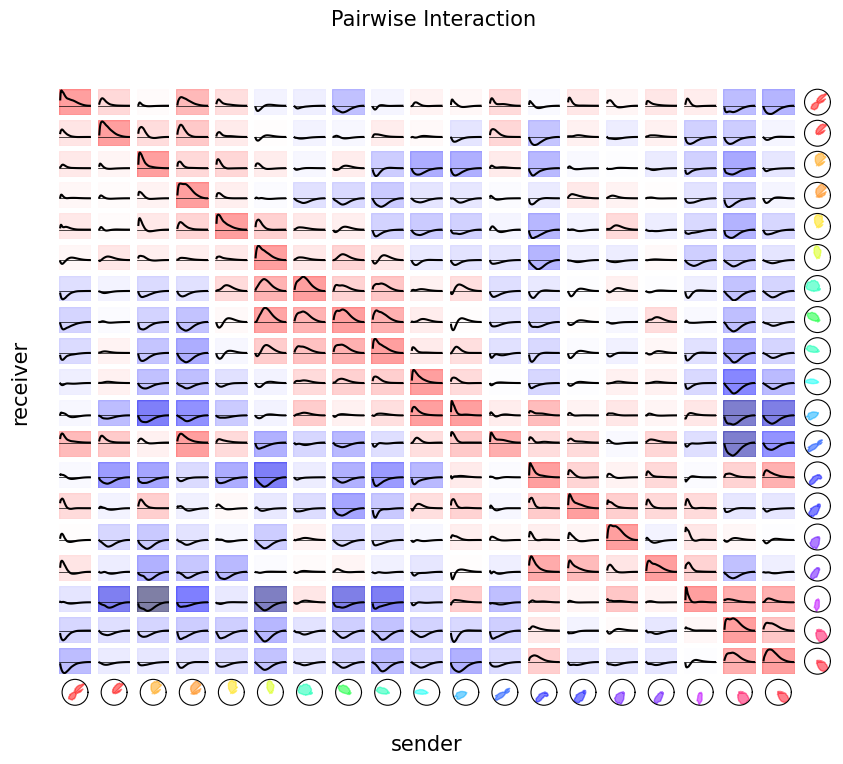

In [71]:
tuning = nap.compute_1d_tuning_curves_continuous(predicted_firing_rate,
                                                 feature=angle,
                                                 nb_bins=61,
                                                 minmax=(0, 2 * np.pi))
                                                 
fig = doc_plots.plot_coupling(responses, tuning)